# Experiments

In [42]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

retriever_checkpoint = "yjernite/retribert-base-uncased"
generator_checkpoint = "yjernite/bart_eli5"

import nlp
import datasets
import os
import json
from tqdm import tqdm
from glob import glob
import faiss
import pandas as pd

%autoreload 2
from lfqa_utils import *

cuda


## Load snippets, models, and lfqa-datasets

### Snippets: Supporting documents

In [44]:
# read snippets
source_dir = '../data/contexts/magazines'
files = glob(os.path.join(source_dir, '*.json'))

magazines_snippets = datasets.load_dataset('json', data_files=files)

Resolving data files:   0%|          | 0/1796 [00:00<?, ?it/s]

Using custom data configuration default-b19f1762f58292c2
Reusing dataset json (/home/mdorosan/.cache/huggingface/datasets/json/default-b19f1762f58292c2/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b)


  0%|          | 0/1 [00:00<?, ?it/s]

In [45]:
display(magazines_snippets)
display(magazines_snippets['train'][0])

DatasetDict({
    train: Dataset({
        features: ['article_title', 'section_title', 'start_paragraph', 'end_paragraph', 'start_character', 'end_character', 'passage_text', 'kicker', 'page', 'index', 'context_id'],
        num_rows: 1796
    })
})

{'article_title': 'My Battle with Pornography',
 'section_title': '',
 'start_paragraph': 2,
 'end_paragraph': 3,
 'start_character': 997,
 'end_character': 1522,
 'passage_text': 'myself that it was natural and ignored any counsel from the Church that told me otherwise. I didn’t realize it at first, but I had become addicted to pornography. The way I looked at girls started to change, and I was ashamed of the thoughts I had. At a youth conference my stake president spoke to us about how looking at pornography makes young men unworthy to exercise the priesthood. His talk convinced me that I needed to stop. At first I thought I could do it on my own. I didn’t want to tell the bishop because I didn’t',
 'kicker': 'No matter how hard I tried to break free from my addiction, I kept losing the battle. I finally learned I couldn’t do it on my own.',
 'page': 26,
 'index': 256,
 'context_id': '26-256-2-997-6ywi'}

In [46]:
# read snippets
source_dir = '../data/contexts/general-conference'
files = glob(os.path.join(source_dir, '*.json'))

gc_snippets = datasets.load_dataset('json', data_files=files)

Resolving data files:   0%|          | 0/187 [00:00<?, ?it/s]

Using custom data configuration default-460b88f4f7d1637b
Reusing dataset json (/home/mdorosan/.cache/huggingface/datasets/json/default-460b88f4f7d1637b/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b)


  0%|          | 0/1 [00:00<?, ?it/s]

In [47]:
display(gc_snippets)
display(gc_snippets['train'][0])

DatasetDict({
    train: Dataset({
        features: ['article_title', 'section_title', 'start_paragraph', 'end_paragraph', 'start_character', 'end_character', 'passage_text', 'kicker', 'page', 'index', 'context_id'],
        num_rows: 187
    })
})

{'article_title': 'Are You Sleeping through the Restoration?',
 'section_title': '',
 'start_paragraph': 0,
 'end_paragraph': 1,
 'start_character': 0,
 'end_character': 544,
 'passage_text': 'Nearly 200 years ago, the American short story “Rip Van Winkle” became an instant classic. The main character, Rip, is an unambitious man who is very good at avoiding two things: work and his wife. One day, while wandering in the mountains with his dog, he discovers a group of strangely dressed men drinking and playing games. After accepting some of their liquor, Rip becomes drowsy and closes his eyes for a moment. When he opens his eyes again, he is surprised to find that his dog is gone, his rifle has rusted, and he now has a long beard.',
 'kicker': 'There is too much at stake for us as individuals, as families, and as Christ’s Church to give only a halfhearted effort to this sacred work.',
 'page': 14,
 'index': 118,
 'context_id': '14-118-0-0-z2f1'}

In [48]:
wiki_snippets = datasets.load_dataset('wiki_snippets', name='wiki40b_en_100_0')['train']

Reusing dataset wiki_snippets (/home/mdorosan/.cache/huggingface/datasets/wiki_snippets/wiki40b_en_100_0/1.0.0/abd9d391450b2f5fd0f943e9c51404eba6d86ee04d07d202b8a311cbcc72e020)


  0%|          | 0/1 [00:00<?, ?it/s]

In [49]:
display(wiki_snippets)
display(wiki_snippets[0])

Dataset({
    features: ['_id', 'datasets_id', 'wiki_id', 'start_paragraph', 'start_character', 'end_paragraph', 'end_character', 'article_title', 'section_title', 'passage_text'],
    num_rows: 17553713
})

{'_id': '{"datasets_id": 0, "wiki_id": "Q1294448", "sp": 2, "sc": 0, "ep": 6, "ec": 610}',
 'datasets_id': 0,
 'wiki_id': 'Q1294448',
 'start_paragraph': 2,
 'start_character': 0,
 'end_paragraph': 6,
 'end_character': 610,
 'article_title': 'Ági Szalóki',
 'section_title': 'Life',
 'passage_text': "Ági Szalóki Life She started singing as a toddler, considering Márta Sebestyén a role model. Her musical background is traditional folk music; she first won recognition for singing with Ökrös in a traditional folk style, and Besh o droM, a Balkan gypsy brass band. With these ensembles she toured around the world from the Montreal Jazz Festival, through Glastonbury Festival to the Théatre de la Ville in Paris, from New York to Beijing.\nSince 2005, she began to pursue her solo career and explore various genres, such as jazz, thirties ballads, or children's songs.\nUntil now, three of her six released albums"}

### LFQA-filtered AR Dataset

In [50]:
# question from general-conference lfqa dataset
source_dir = "../data/lfqa-filtered/qa-3/general-conference"
files = glob(os.path.join(source_dir, "*.json"))
gc_lfqa = datasets.load_dataset('json', data_files=files)

Using custom data configuration default-e9dc0a5056ef4b3d
Reusing dataset json (/home/mdorosan/.cache/huggingface/datasets/json/default-e9dc0a5056ef4b3d/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b)


  0%|          | 0/1 [00:00<?, ?it/s]

In [51]:
# question from general-conference lfqa dataset
source_dir = "../data/lfqa-filtered/qa-3/magazines"
files = glob(os.path.join(source_dir, "*.json"))
mag_lfqa = datasets.load_dataset('json', data_files=files)

Resolving data files:   0%|          | 0/72 [00:00<?, ?it/s]

Using custom data configuration default-48c3abd676790e8b
Reusing dataset json (/home/mdorosan/.cache/huggingface/datasets/json/default-48c3abd676790e8b/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b)


  0%|          | 0/1 [00:00<?, ?it/s]

### Models and Tokenizers

In [52]:
from transformers import AutoTokenizer, AutoModel

# use retriever model for both tokenizer and model
retriever_tokenizer = AutoTokenizer.from_pretrained(retriever_checkpoint)
retriever_model = AutoModel.from_pretrained(retriever_checkpoint).to('cuda:0')

_ = retriever_model.eval()

Some weights of RetriBertModel were not initialized from the model checkpoint at yjernite/retribert-base-uncased and are newly initialized: ['bert_query.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
# load tokenizer and model
from transformers import AutoModelForSeq2SeqLM

generator_tokenizer = AutoTokenizer.from_pretrained('yjernite/bart_eli5')
generator_model = AutoModelForSeq2SeqLM.from_pretrained('yjernite/bart_eli5').to('cuda:0')
_ = generator_model.eval()

## Create GPU index

### `magazines-index.dat`

In [54]:
faiss_res = faiss.StandardGpuResources()
max_length = 128

# reading the embeddings into ram
magazines_embeddings = np.memmap(
    'context-index/magazines-index.dat', 
    dtype='float32', mode='r',
    shape=(magazines_snippets['train'].num_rows, max_length)
)

# create the gpu index
magazines_index_flat = faiss.IndexFlatIP(max_length) # 128 fits in GPU
magazines_gpu_index = faiss.index_cpu_to_gpu(provider=faiss_res, device=0, index=magazines_index_flat)

# saving the embeddings into gpu index for faster retrieval time
magazines_gpu_index.add(magazines_embeddings)

### `general-conference-index.dat`

In [55]:
faiss_res = faiss.StandardGpuResources()
max_length = 128

# reading the embeddings into ram
gc_embeddings = np.memmap(
    'context-index/general-conference-index.dat', 
    dtype='float32', mode='r',
    shape=(gc_snippets['train'].num_rows, max_length)
)

# create the gpu index
gc_index_flat = faiss.IndexFlatIP(max_length) # 128 fits in GPU
# gc_gpu_index = faiss.index_cpu_to_gpu(provider=faiss_res, device=0, index=gc_index_flat)

# saving the embeddings into gpu index for faster retrieval time
# gc_gpu_index.add(gc_embeddings)

### `wiki40b_passages_reps_32_l-8_h-768_b-512-512.dat`

In [56]:
wiki_snippets[0]

{'_id': '{"datasets_id": 0, "wiki_id": "Q1294448", "sp": 2, "sc": 0, "ep": 6, "ec": 610}',
 'datasets_id': 0,
 'wiki_id': 'Q1294448',
 'start_paragraph': 2,
 'start_character': 0,
 'end_paragraph': 6,
 'end_character': 610,
 'article_title': 'Ági Szalóki',
 'section_title': 'Life',
 'passage_text': "Ági Szalóki Life She started singing as a toddler, considering Márta Sebestyén a role model. Her musical background is traditional folk music; she first won recognition for singing with Ökrös in a traditional folk style, and Besh o droM, a Balkan gypsy brass band. With these ensembles she toured around the world from the Montreal Jazz Festival, through Glastonbury Festival to the Théatre de la Ville in Paris, from New York to Beijing.\nSince 2005, she began to pursue her solo career and explore various genres, such as jazz, thirties ballads, or children's songs.\nUntil now, three of her six released albums"}

In [57]:
faiss_res = faiss.StandardGpuResources()
max_length = 128

# reading the embeddings into ram
wiki_embeddings = np.memmap(
    'context-index/wiki40b_passages_reps_32_l-8_h-768_b-512-512.dat', 
    dtype='float32', mode='r',
    shape=(wiki_snippets.num_rows, max_length)
)

# create the gpu index
wiki_index_flat = faiss.IndexFlatIP(max_length) # 128 fits in GPU
wiki_index_flat.add(wiki_embeddings)

# wiki_gpu_index = faiss.index_cpu_to_gpu(provider=faiss_res, device=0, index=wiki_index_flat)

# saving the embeddings into gpu index for faster retrieval time
# wiki_gpu_index.add(wiki_embeddings)

## Inspect AR-LFQA

In [58]:
answer_size = 3
files = glob(f"../data/lfqa-filtered/qa-{answer_size}/magazines/*.json")

to_pandas = []
for file in tqdm(files):
    fname = file.split("/")[-1]
    with open(file, 'r') as f:
        data = json.load(f)
    to_write = {
        "Question": data['title'],
        "Answer": data["answers"]["text"][0],
    }
    to_pandas.append(to_write)
json_str = json.dumps(to_pandas)

mag_df = pd.read_json(json_str, orient='records')
print(mag_df.shape)
mag_df = mag_df.drop_duplicates(subset='Question')
print(mag_df.shape)
mag_df.head()

100%|██████████| 72/72 [00:00<00:00, 2639.33it/s]

(72, 2)
(72, 2)


,Question,Answer
0,Do we obey out of fear of punishment?,"It is probably better to be obedient out of fear than to not be obedient. A child might stop hitting his sister for fear of a scolding from his parents. Later, his reason should rise to the higher motive of being kind."
1,How can you keep your life on the course that will take you home to Heavenly Father?,"You can do this by staying in constant contact with Him through prayer. He can see things that you cannot see. And if you will stay in constant contact with Him, He will lovingly lead you back home."
2,So what was keeping me from entering the waters of baptism?,I always had an excuse. I worked long hours. I didn’t see that I’d ever have time for the gospel.
3,Why was this trigger different?,Have you been stressed out lately? How were you feeling emotionally? Did going some time with no scripture study weaken you?
4,Is something in your prevention plan not helpful?,"What can you do differently next time? Write down what you are learning and keep going! Jesus Christ can help you in the growing process of repentance, and He has the power to enable you as you strive to overcome pornography."


In [59]:
answer_size = 3
files = glob(f"../data/lfqa-filtered/qa-{answer_size}/general-conference/*.json")

to_pandas = []
for file in tqdm(files):
    fname = file.split("/")[-1]
    with open(file, 'r') as f:
        data = json.load(f)
    to_write = {
        "Question": data['title'],
        "Answer": data["answers"]["text"][0],
    }
    to_pandas.append(to_write)
json_str = json.dumps(to_pandas)

gc_df = pd.read_json(json_str, orient='records')
print(gc_df.shape)
gc_df = gc_df.drop_duplicates(subset='Question')
print(gc_df.shape)
gc_df.head()

100%|██████████| 12/12 [00:00<00:00, 3075.94it/s]

(12, 2)
(12, 2)


,Question,Answer
0,"When our time in mortality is complete, what experiences will we be able to share about our own contribution to this significant period of our lives and to the furthering of the Lord’s work?","Will we be able to say that we rolled up our sleeves and labored with all our heart, might, mind, and strength? Or will we have to admit that our role was mostly that of an observer? I suppose there are a variety of reasons why it is easy to become a bit sleepy with regard to building the kingdom of God."
1,What is the remedy?,"The answer, as always, lies in the words of Christ: “Whosoever will come after me, let him deny himself, and take up his cross, and follow me. “For whosoever will save his life shall lose it; but whosoever shall lose his life for my sake and the gospel’s, the same shall save it.”5"
2,But what of those who find themselves in the grip of addiction?,"Please know, first of all, that there is hope. Seek help from loved ones, Church leaders, and trained counselors. The Church provides addiction recovery help through local Church leaders, the Internet,7 and in some areas, LDS Family Services."
3,"All these things may be good and honorable, but are they leaving us time and energy for what should be our highest priorities?","What is the remedy? Once again, it comes from the words of the Savior: “Thou shalt love the Lord thy God with all thy heart, and with all thy soul, and with all thy mind."
4,“How long will ye suffer [yourself] to be led by foolish and blind guides?,"Yea, how long will ye choose darkness rather than light?” (Hel. 13:29.) Choose to change—today!"


## Answers Evaluation

### Generate Aswers

In this section we evaluate the model's ROUGE scores against the actual answers. Comparisons are made among:
1. A generator using retrieved closed-domain AR supporting documents as reference: question + support (within domain)
2. A generator using retrieved wikipedia domain supporting documents as reference: question + support (out of domain)
3. A generator using only the question (i.e., blank contexts) as inputs

#### Within Context: Question and supporting documents coming from AR domain

In [60]:
num_qs = gc_lfqa['train'].num_rows
questions = []
actual_answers = []
generated_answers = []
input_token_count = []
support_docs = []

for i in range(num_qs):
    question = gc_lfqa['train'][i]['title']
    actual_answer = gc_lfqa['train'][i]['answers']['text']
    doc, res_list = query_qa_dense_index(
        question, 
        retriever_model, 
        retriever_tokenizer, 
        magazines_snippets['train'], 
        magazines_gpu_index,
        10, # support count
    )
    
    
    # concetante into a format taken by the model
    question_doc = "question: {} context: {}".format(question, doc)
    support_docs += [doc]
    # get input token count for inspection against 1024 input length
    input_token_count += ([len(retriever_tokenizer.tokenize(question_doc))]) 
    
    # generate an answer with beam search, explore nucleus search
    generated_answer = qa_s2s_generate(
            question_doc, generator_model, generator_tokenizer,
            num_answers=1,
            num_beams=8,
            min_len=64,
            max_len=256,
            max_input_length=1024,
            device="cuda:0"
    )[0]        
    generated_answers += [generated_answer]
    questions += [question]
    actual_answers += [actual_answer]

/home/mdorosan/.conda-envs/torch2022/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2271: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (2608 > 512). Running this sequence through the model will result in indexing errors


In [61]:
df_within_context = pd.DataFrame({
    'Question': questions,
    'Actual Answer': np.array(actual_answers).flatten().tolist(),
    'Generated Answer': generated_answers,
    'Input Token Count' : input_token_count,
    'Support Docs': support_docs,
})

df_within_context.style.set_properties(**{'text-align': 'right'})
display(df_within_context[['Question', 'Generated Answer']])

,Question,Generated Answer
0,"When our time in mortality is complete, what experiences will we be able to share about our own contribution to this significant period of our lives and to the furthering of the Lord’s work?","I don’t think there’s a definitive answer to this question, but I’d like to say that you’ll be able to learn more about your own contribution to this significant period of your life and to the furthering of the work of the Lord. You’re going to have to be more specific, though."
1,What is the remedy?,"It's not a remedy, it's a way to get rid of an addiction. Addiction is a chemical imbalance in the brain, and the solution is to take away the chemicals that cause the imbalance, and replace them with something else that doesn't have the same effect. For example, if you're addicted to nicotine, you might want to stop taking it, because it's bad for you. But if you don't take it, you'll just keep taking more and more of it, until you stop taking any at all."
2,But what of those who find themselves in the grip of addiction?,"It’s not so much that they’re in the grip of addiction as it is that they don’t know how to stop it. They’ve been addicted for so long that their brain has become desensitized to the withdrawal symptoms, and they can no longer tell the difference between “I’m addicted” and “not addicted.”"
3,"All these things may be good and honorable, but are they leaving us time and energy for what should be our highest priorities?","No, not really. There is no such thing as ""time and energy for what should be our highest priorities"". Time and energy is a finite resource, and you can only use so much of it at a time. If you want to use more of it, you have to spend more time doing something else."
4,“How long will ye suffer [yourself] to be led by foolish and blind guides?,"I'm not sure what you mean by ""foolish and blind guides"". If you're asking how long it would take for you to be led by a foolish and blind guide, I don't know. If you mean how long you'd have to suffer the consequences of your actions, I can't answer that."
5,"Do you realize how deeply the Lord loves and cherishes you, even now?","I don't think you realize how deeply the Lord loves and cherishes you, even now. You just don't realize the extent to which you are loved and cherished by the people who love and cherish you. It's not something you think about, it's just something you do. You don't have to think about it, you just do."
6,"Brothers and sisters, how do we protect our children and youth?","Don't be a jerk to your children. Don't beat them up, don't be mean to them, and don't do anything you wouldn't do to a sibling or sibling-in-law. It's all about being a good parent, and if you can't do it, you shouldn't try to do it."
7,How do we lead our children to deep conversion and to access our Savior’s Atonement?,"I don’t think it’s so much about converting them as it is about teaching them how to accept Christ as their savior. I’m not sure what you mean by “how do we’re supposed to lead our children to deep conversion”, but I do think it has something to do with teaching them to accept Jesus Christ as the Son of God."
8,What do I want my grandchildren to know?,"I don't want my grandchildren to know anything about me or my family. I want them to know as much as they can about their grandparents and great-grandparents, and to learn as much about their great-great-great grandparents as well. If they're old enough, they might be able to learn more about their family, but that's about it."
9,How do we decide where our repentance should be focused?,"I don't think there is a definitive answer to this question. There are a lot of things you can do to make your life better, but I think the most important thing is to make sure you are willing to accept the consequences of your actions. If you don't want to accept those consequences, don't do them."


#### Out of context: Supporting documents coming from wiki domain

In [62]:
num_qs = gc_lfqa['train'].num_rows
questions = []
actual_answers = []
generated_answers = []
input_token_count = []
support_docs = []

for i in range(num_qs):
    question = gc_lfqa['train'][i]['title']
    actual_answer = gc_lfqa['train'][i]['answers']['text']
    doc, res_list = query_qa_dense_index(
        question, 
        retriever_model, 
        retriever_tokenizer, 
        wiki_snippets, 
        wiki_index_flat,
        10, # supports
    )
    
    
    # concetante into a format taken by the model
    question_doc = "question: {} context: {}".format(question, doc)
    support_docs += [doc]
    # get input token count for inspection against 1024 input length
    input_token_count += ([len(retriever_tokenizer.tokenize(question_doc))]) 
    
    # generate an answer with beam search, explore nucleus search
    generated_answer = qa_s2s_generate(
            question_doc, generator_model, generator_tokenizer,
            num_answers=1,
            num_beams=8,
            min_len=64,
            max_len=256,
            max_input_length=1024,
            device="cuda:0"
    )[0]        
    generated_answers += [generated_answer]
    questions += [question]
    actual_answers += [actual_answer]

/home/mdorosan/.conda-envs/torch2022/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2271: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [63]:
df_out_context = pd.DataFrame({
    'Question': questions,
    'Actual Answer': np.array(actual_answers).flatten().tolist(),
    'Generated Answer': generated_answers,
    'Input Token Count' : input_token_count,
    'Support Docs': support_docs,
})

df_out_context.style.set_properties(**{'text-align': 'right'})
display(df_out_context[['Question', 'Generated Answer']])

,Question,Generated Answer
0,"When our time in mortality is complete, what experiences will we be able to share about our own contribution to this significant period of our lives and to the furthering of the Lord’s work?","Your time in mortality is not complete. There is no such thing as ""time in mortality"". You are still alive, and you are still contributing to the work of the Lord. When you die, you are no longer contributing to God's work, but you will still be contributing to your friends and family, and to the world."
1,What is the remedy?,"It’s a placebo effect. You’re not supposed to take it, but if you do, it’ll make you feel better. If you don’t take it and feel better, you’ve done something wrong, and the placebo effect will take care of it for you."
2,But what of those who find themselves in the grip of addiction?,"I'm not an expert, but I think it has something to do with the fact that addiction is a chemical addiction. It's not a physical addiction, it's not an emotional addiction, or a psychological addiction. Addiction is a biological response to a chemical imbalance in the brain. When you have an imbalance in your brain, it makes it harder for you to do things you want to do."
3,"All these things may be good and honorable, but are they leaving us time and energy for what should be our highest priorities?","No, not really. It's not that they're leaving you time and energy for what should be your highest priorities, it's that the things you consider to be ""high priorities"" aren't necessarily the things that are going to be the most important things for you to do in the future. For example, if you want to be a good person, you're going to have to do a lot of work to make that happen. If you don't want to do that work, then you're not going to do it."
4,“How long will ye suffer [yourself] to be led by foolish and blind guides?,"It's not so much that you'll suffer, it's that you won't be able to tell the difference between a guide and a blind person. If you can't tell them apart, you're going to end up in a lot of trouble. If they can tell you apart, then you're not going to be in any trouble."
5,"Do you realize how deeply the Lord loves and cherishes you, even now?","Do you realize how deeply the Lord loves and cherishes you, even now? If you do, then yes. If you don't, then no. There's no way to answer that question without knowing how deeply you love and cherish the Lord. It's not a question that can be answered without knowing the answer."
6,"Brothers and sisters, how do we protect our children and youth?","Don't let anyone tell you what to do. Do what you think is best for your children. Don't force them to do anything they don't want to do, and don't tell them what they can and can't do. That way, if they do something bad, you don't have to be the one to blame."
7,How do we lead our children to deep conversion and to access our Savior’s Atonement?,"It’s not so much about converting them as it is about teaching them how to live in a way that allows them to receive the Atonement. There are a lot of different ways to do this, but the basic idea is that you teach them to love God and to love others. You teach them that they are loved by God, and that they can be saved if they choose to accept Jesus as their savior."
8,What do I want my grandchildren to know?,"You want them to know that you love them, and that you care about them. That you are a good person. And that you will take care of them when they are old enough to care for themselves. If you don't care for them, don't do anything about it. If they do care for you, let them know that they love you."
9,How do we decide where our repentance should be focused?,"It depends on what you mean by ""remitration"" and what you're trying to accomplish. If you're talking about ""repentance"" as in, ""I'm sorry for what I did, I'm going to try to do better in the future"" then you're going to focus on the things you did wrong, and the things that caused you to do them

In [64]:
gc_lfqa.num_rows

{'train': 12}

In [65]:
mag_lfqa.num_rows

{'train': 72}

#### No context: Only question and empy supporting document is fed into generator

In [66]:
num_qs = gc_lfqa['train'].num_rows
questions = []
actual_answers = []
generated_answers = []
input_token_count = []
support_docs = []

for i in range(num_qs):
    question = gc_lfqa['train'][i]['title']
    # no retrieval step here: using generator trained on ELI5

    # concetante into a format taken by the model
    question_doc = "question: {} context: {}".format(question, '')
    support_docs += ['']
    # get input token count for inspection against 1024 input length
    input_token_count += ([len(retriever_tokenizer.tokenize(question_doc))]) 
    
    # generate an answer with beam search, explore nucleus search
    generated_answer = qa_s2s_generate(
            question_doc, generator_model, generator_tokenizer,
            num_answers=1,
            num_beams=8,
            min_len=64,
            max_len=256,
            max_input_length=1024,
            device="cuda:0"
    )[0]        
    generated_answers += [generated_answer]
    questions += [question]
    actual_answers += [actual_answer]

In [67]:
df_no_context = pd.DataFrame({
    'Question': questions,
    'Actual Answer': np.array(actual_answers).flatten().tolist(),
    'Generated Answer': generated_answers,
    'Input Token Count' : input_token_count,
    'Support Docs': support_docs,
})

df_no_context.style.set_properties(**{'text-align': 'right'})
display(df_no_context[['Question', 'Generated Answer']])

,Question,Generated Answer
0,"When our time in mortality is complete, what experiences will we be able to share about our own contribution to this significant period of our lives and to the furthering of the Lord’s work?","I'm not sure what you mean by ""question"" but I'd like to know the answer to that as well. I'm guessing you're talking about the question ""What experiences will we be able to share about our own contribution to the significant amount of our contribution to this significant period of our lives and to the proportion of our contributions to the major factor of our size and importance to the global economy?"" The answer is that we don't know."
1,What is the remedy?,"The ""M"" in ""Meter"" is the Latin word for ""measure"", and the ""T"" is Latin for ""time"". So, the *M* in ""Measure"" means ""time"" and the *T* in the word ""Time"" is ""time."" So, a *measure* is a time, and a *ton* is the amount of time it takes to do something."
2,But what of those who find themselves in the grip of addiction?,"I'm not an expert, but I believe it has something to do with the fact that addiction is a mental illness, not a physical illness. It's not a disease, it's a mental disorder. I don't think it's something that can be cured. I think it can be treated, but it's not something that you can cure."
3,"All these things may be good and honorable, but are they leaving us time and energy for what should be our highest priorities?","> All these things may be good and honorable, but are they leaving us time and energy for what should be our highest priorities? Yes, they are. It's just that the amount of energy that is leaving us is much less than the amount that is being put into us, so it's not the highest priority."
4,“How long will ye suffer [yourself] to be led by foolish and blind guides?,"I'm not sure what context you're looking for, but [this]( URL_0 ) is a pretty good example of what you're talking about. It's a bit more complicated than that, but the general idea is that you have two people, one with a sword, and one without a sword. One of the people has a sword and one has a bow. The sword is the one with the sword, the other the one without the sword. So, the sword has a lot more power than the bow, and the sword is much more powerful than the second person. The second person has no sword, so the sword can't be as powerful as the first person's sword."
5,"Do you realize how deeply the Lord loves and cherishes you, even now?","URL_0 > Do you realize how deeply the Lord loves and cherishes you, even now? > Yes, you do. You realize how much he loves & cherishes *you,* even now. And you realize that he *also* loves and *cares* *for* *you*."
6,"Brothers and sisters, how do we protect our children and youth?","I'm not sure what you mean by ""how do we protect our children and youth"" but I'm pretty sure it has something to do with the fact that we have a lot of children. I'm sure there's a lot more to it than that, but that's the gist of it. Also, I think it's important to note that it's not just the children that you have to worry about, it's the parents as well."
7,How do we lead our children to deep conversion and to access our Savior’s Atonement?,"URL_0 URL_1 This is a pretty good video that explains how it works. It's a bit long, but I think it's worth a watch. I'm not an expert on the subject, so I can't give you a more detailed explanation, but it's a good video."
8,What do I want my grandchildren to know?,"It's like asking what do I want my dog to do when I ask it to do something. It doesn't know, it doesn't care, it's just going to do it anyway. The same thing applies to my grandchildren. I don't want my grandchildren to know, but I do want them to know."
9,How do we decide where our repentance should be focused?,"> How do we decide where our repentance should be focused? We don't. We choose where we want our repentance to be focused on. > What is the best way to focus on it? The best way is to be aware of it. If yo

### Evaluate Answers

In [68]:
rouge = datasets.load_metric('rouge')
from rouge_score import rouge_scorer

#### Reference answer ROUGE Scores

In [69]:
generated = df_within_context['Generated Answer'].tolist()
actual = df_within_context['Actual Answer'].tolist()

scores = rouge.compute(
    predictions=generated,
    references=actual, 
    rouge_types=['rouge1', 'rouge2', 'rougeL'],
    use_agregator=True,
    use_stemmer=False,)


df_within_results = pd.DataFrame({
    'rouge1': [scores['rouge1'].mid.precision, scores['rouge1'].mid.recall, scores['rouge1'].mid.fmeasure],
    'rouge2': [scores['rouge2'].mid.precision, scores['rouge2'].mid.recall, scores['rouge2'].mid.fmeasure],
    'rougeL': [scores['rougeL'].mid.precision, scores['rougeL'].mid.recall, scores['rougeL'].mid.fmeasure],
}, index=[ 'P', 'R', 'F'])
df_within_results.style.format({'rouge1': "{:.4f}", 'rouge2': "{:.4f}", 'rougeL': "{:.4f}"})

,rouge1,rouge2,rougeL
P,0.1971,0.0259,0.1192
R,0.2262,0.0322,0.1392
F,0.2024,0.0274,0.1224


In [70]:
generated = df_out_context['Generated Answer'].tolist()
actual = df_out_context['Actual Answer'].tolist()

scores = rouge.compute(
    predictions=generated,
    references=actual, 
    rouge_types=['rouge1', 'rouge2', 'rougeL'],
    use_agregator=True,
    use_stemmer=False,)

df_out_results = pd.DataFrame({
    'rouge1': [scores['rouge1'].mid.precision, scores['rouge1'].mid.recall, scores['rouge1'].mid.fmeasure],
    'rouge2': [scores['rouge2'].mid.precision, scores['rouge2'].mid.recall, scores['rouge2'].mid.fmeasure],
    'rougeL': [scores['rougeL'].mid.precision, scores['rougeL'].mid.recall, scores['rougeL'].mid.fmeasure],
}, index=[ 'P', 'R', 'F'])
df_out_results.style.format({'rouge1': "{:.4f}", 'rouge2': "{:.4f}", 'rougeL': "{:.4f}"})

,rouge1,rouge2,rougeL
P,0.1786,0.0145,0.1090
R,0.1989,0.0155,0.1254
F,0.1805,0.0146,0.1112


Despite the advantage of the wikipedia supporting documents as added context to a question, a much smaller corpus of support documents that are more aligned with the context of the line of questioning yield comparable scores across precision, recall, and f-beta of ROUGE variants (i.e., 1-gram, 2-gram, longest common sequence variant).

In [71]:
generated = df_no_context['Generated Answer'].tolist()
actual = df_no_context['Actual Answer'].tolist()

scores = rouge.compute(
    predictions=generated,
    references=actual, 
    rouge_types=['rouge1', 'rouge2', 'rougeL'],
    use_agregator=True,
    use_stemmer=False,)

df_no_results = pd.DataFrame({
    'rouge1': [scores['rouge1'].mid.precision, scores['rouge1'].mid.recall, scores['rouge1'].mid.fmeasure],
    'rouge2': [scores['rouge2'].mid.precision, scores['rouge2'].mid.recall, scores['rouge2'].mid.fmeasure],
    'rougeL': [scores['rougeL'].mid.precision, scores['rougeL'].mid.recall, scores['rougeL'].mid.fmeasure],
}, index=[ 'P', 'R', 'F'])
df_no_results.style.format({'rouge1': "{:.4f}", 'rouge2': "{:.4f}", 'rougeL': "{:.4f}"})

,rouge1,rouge2,rougeL
P,0.1011,0.0057,0.0708
R,0.2111,0.0115,0.1472
F,0.1352,0.0074,0.0944


#### Supporting Documents ROUGE scores

##### Within Context

In [31]:
def get_rouges(answers, supp_docs, rouge_type='rouge1'):
    ans_rouges = []
    for index, ans in enumerate(answers):
        precisions = []
        recalls = []
        fbetas = []
        docs = list(set(supp_docs[index].split('<P>')))
        for doc in docs:
            if len(doc) == 0:
                continue
            scorer = rouge_scorer.RougeScorer(rouge_types=[rouge_type], 
                                              use_stemmer=False)
            scores = scorer.score(doc, ans)

            precisions.append(scores[rouge_type].precision)
            recalls.append(scores[rouge_type].recall)
            fbetas.append(scores[rouge_type].fmeasure)
        ans_rouges.append({f'{rouge_type}_precision': np.max(precisions),
                           f'{rouge_type}_recall': np.max(recalls),
                           f'{rouge_type}_f1': np.max(fbetas),
                          })

    supp_rouges = []
    for index, concat_docs in enumerate(supp_docs):
        docs = list(set(concat_docs.split('<P>')))

        jk_precisions = []
        jk_recalls = []
        jk_fbetas = []

        for index, doc in enumerate(docs):
            if len(doc) == 0:
                continue
            precisions = []
            recalls = []
            fbetas = []
            for index2, other in enumerate(docs):
                if index==index2:
                    continue
                else:
                    if len(doc) == 0:
                        continue
                    scorer = rouge_scorer.RougeScorer(rouge_types=[rouge_type], 
                                                      use_stemmer=False)
                    scores = scorer.score(doc, other)

                jk_precisions.append(scores[rouge_type].precision)
                jk_recalls.append(scores[rouge_type].recall)
                jk_fbetas.append(scores[rouge_type].fmeasure)
        # returns the max ROUGE obtained from support documents
        supp_rouges.append({f'{rouge_type}_precision': np.max(jk_precisions),
                           f'{rouge_type}_recall': np.max(jk_recalls),
                           f'{rouge_type}_f1': np.max(jk_fbetas),})
    return ans_rouges, supp_rouges

In [32]:
df_within_context.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Question           12 non-null     object
 1   Actual Answer      12 non-null     object
 2   Generated Answer   12 non-null     object
 3   Input Token Count  12 non-null     int64 
 4   Support Docs       12 non-null     object
dtypes: int64(1), object(4)
memory usage: 608.0+ bytes


In [33]:
rouge_types = ['rouge1', 'rouge2', 'rougeL']
supp_docs = df_within_context['Support Docs'].tolist()

for rouge_type in tqdm(rouge_types):
    answers = df_within_context['Generated Answer'].tolist()
    ans_rouges, _ = get_rouges(answers, supp_docs, 
                               rouge_type=rouge_type)
    ans_df = pd.DataFrame(ans_rouges)
    for col in ans_df.columns:
        df_within_context[f'ans_{col}'] = ans_df[col]
    
    answers = df_within_context['Actual Answer'].tolist()
    ref_rouges, _ = get_rouges(answers, supp_docs, 
                               rouge_type=rouge_type)
    ref_df = pd.DataFrame(ref_rouges)
    for col in ref_df.columns:
        df_within_context[f'ref_{col}'] = ref_df[col]
        
df_within_context.info()

100%|██████████| 3/3 [00:32<00:00, 10.84s/it]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Question              12 non-null     object 
 1   Actual Answer         12 non-null     object 
 2   Generated Answer      12 non-null     object 
 3   Input Token Count     12 non-null     int64  
 4   Support Docs          12 non-null     object 
 5   ans_rouge1_precision  12 non-null     float64
 6   ans_rouge1_recall     12 non-null     float64
 7   ans_rouge1_f1         12 non-null     float64
 8   ref_rouge1_precision  12 non-null     float64
 9   ref_rouge1_recall     12 non-null     float64
 10  ref_rouge1_f1         12 non-null     float64
 11  ans_rouge2_precision  12 non-null     float64
 12  ans_rouge2_recall     12 non-null     float64
 13  ans_rouge2_f1         12 non-null     float64
 14  ref_rouge2_precision  12 non-null     float64
 15  ref_rouge2_recall     12 

##### Out of context

In [34]:
rouge_types = ['rouge1', 'rouge2', 'rougeL']
supp_docs = df_out_context['Support Docs'].tolist()

for rouge_type in tqdm(rouge_types):
    answers = df_out_context['Generated Answer'].tolist()
    ans_rouges, _ = get_rouges(answers, supp_docs, 
                               rouge_type=rouge_type)
    ans_df = pd.DataFrame(ans_rouges)
    for col in ans_df.columns:
        df_out_context[f'ans_{col}'] = ans_df[col]
    
    answers = df_out_context['Actual Answer'].tolist()
    ref_rouges, _ = get_rouges(answers, supp_docs, 
                               rouge_type=rouge_type)
    ref_df = pd.DataFrame(ref_rouges)
    for col in ref_df.columns:
        df_out_context[f'ref_{col}'] = ref_df[col]
        
df_within_context.info()

100%|██████████| 3/3 [00:32<00:00, 10.89s/it]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Question              12 non-null     object 
 1   Actual Answer         12 non-null     object 
 2   Generated Answer      12 non-null     object 
 3   Input Token Count     12 non-null     int64  
 4   Support Docs          12 non-null     object 
 5   ans_rouge1_precision  12 non-null     float64
 6   ans_rouge1_recall     12 non-null     float64
 7   ans_rouge1_f1         12 non-null     float64
 8   ref_rouge1_precision  12 non-null     float64
 9   ref_rouge1_recall     12 non-null     float64
 10  ref_rouge1_f1         12 non-null     float64
 11  ans_rouge2_precision  12 non-null     float64
 12  ans_rouge2_recall     12 non-null     float64
 13  ans_rouge2_f1         12 non-null     float64
 14  ref_rouge2_precision  12 non-null     float64
 15  ref_rouge2_recall     12 

In [35]:
# grouped box plots: theme recall
metric = 'recall'
group_names = {
    'ref': 'Reference',
    'ans': 'Generated',
}

frame_list = []
for col in df_within_context.columns:
    temp_df = pd.DataFrame()
    col_split = col.split('_')
    if len(col_split) != 3:
        continue
    if col_split[2] == metric:
        temp_df['ROUGE Recall'] = df_within_context[col]
        temp_df['Group'] = group_names[col_split[0]]
        temp_df['Type'] = col_split[1]
        frame_list.append(temp_df)

# change rouge type label
recall_df = pd.concat(frame_list)

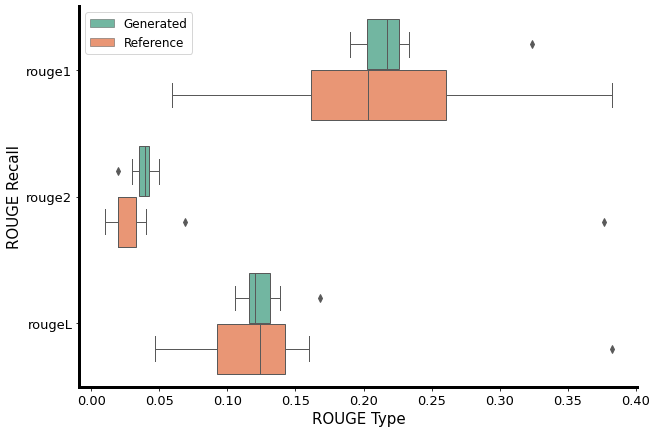

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

_, ax = plt.subplots(figsize=(10, 7))

sns.boxplot(
    x='ROUGE Recall', 
    y='Type', 
    hue='Group', 
    data=recall_df, 
    palette='Set2', 
    ax=ax, 
    orient='h',
    linewidth=1)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# set spines lw
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=13)
ax.set_xlabel("ROUGE Type", fontsize=15)
ax.set_ylabel("ROUGE Recall", fontsize=15)
ax.legend(fontsize=12)
plt.savefig('images/answer_supp_overlap.png', bbox_inches='tight')
plt.show()

#### Inspect support doc contents

In [ ]:
sorted_test = df_within_context.sort_values('ref_rouge1_recall', ascending=False)
sorted_test.iloc[0]

#### Support Document Length Distribution

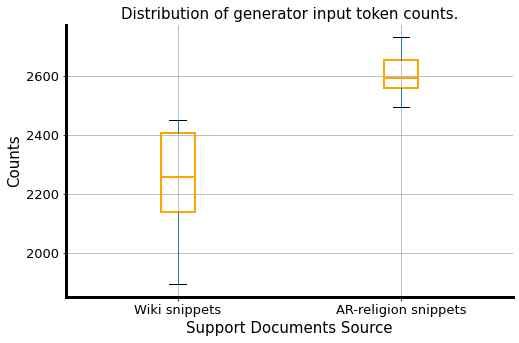

In [37]:
import matplotlib.pyplot as plt
_, ax = plt.subplots(figsize=(8, 5))

token_count_df = pd.DataFrame()
token_count_df['Wiki snippets'] = df_out_context['Input Token Count']
token_count_df['AR-religion snippets'] = df_within_context['Input Token Count']


boxprops = dict(linestyle='-', linewidth=2, color='orange')
medianprops = dict(linestyle='-', linewidth=2, color='orange')

token_count_df.boxplot(ax=ax, showmeans=False, medianprops=medianprops,
                       boxprops=boxprops,)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# set spines lw
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)

ax.set_xlabel("Support Documents Source", fontsize=15)
ax.set_ylabel("Counts", fontsize=15)
ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=13)
ax.set_title("Distribution of generator input token counts.", fontsize=15)
plt.savefig('images/token_counts.png', bbox_inches='tight')
plt.show()

#### Retrieval Results Inpsection

In [38]:
test_question = "How do I quit my addiction?"

doc, res_list = query_qa_dense_index(
    test_question, 
    retriever_model, 
    retriever_tokenizer, 
    magazines_snippets['train'], 
    magazines_gpu_index,
    10
)

df = pd.DataFrame({
    'Article': ['---'] + [res['article_title'] for res in res_list],
    'Sections': ['---'] + [res['section_title'] if res['section_title'].strip() != '' else res['article_title']
                 for res in res_list],
    'Text': ['--- Question: ' + test_question] + [res['passage_text'] for res in res_list],
})
df.style.set_properties(**{'text-align': 'left'})

/home/mdorosan/.conda-envs/torch2022/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2271: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


,Article,Sections,Text
0,---,---,--- Question: How do I quit my addiction?
1,Overcoming the Plague of Addiction,Overcoming the Plague of Addiction,"broken free from their addiction can testify of the learning that came through their personal victory over their vice. For Family Members and Friends Addiction should not be viewed only as a moral weakness but as a multifaceted challenge that virtually anyone could face. If you know someone struggling with an addiction, there are any number of things you should consider doing and some you should consider not doing. While the following suggestions are not an exhaustive list and will vary depending on the specific situation, you could prayerfully consider each: A little prevention is worth a lot of cure."
2,Overcoming the Plague of Addiction,Overcoming the Plague of Addiction,"addiction continuum once the habit starts. If you are wondering if a loved one is on the path to addiction, there are many resources available to help, in your community as well as online. The responsibility for change falls to each individual. While family and friends can be supportive, they cannot interfere with someone else’s agency. If the individual has no desire to change, no form of treatment will be successful. The path to recovery can be different for each individual. Due to the relative strengths and weaknesses of the four unique factors mentioned previously (biological, psychological, social, and spiritual),"
3,Are You Sleeping through the Restoration?,Are You Sleeping through the Restoration?,"should not do, let us listen to the loving warning of trusted family and friends, our beloved prophet, and always the Savior. The best defense against addiction is never to start. But what of those who find themselves in the grip of addiction? Please know, first of all, that there is hope. Seek help from loved ones, Church leaders, and trained counselors. The Church provides addiction recovery help through local Church leaders, the Internet,7 and in some areas, LDS Family Services. Always remember, with the Savior’s help, you can break free from addiction. It may be a long, difficult path,"
4,Are You Sleeping through the Restoration?,Are You Sleeping through the Restoration?,"should not do, let us listen to the loving warning of trusted family and friends, our beloved prophet, and always the Savior. The best defense against addiction is never to start. But what of those who find themselves in the grip of addiction? Please know, first of all, that there is hope. Seek help from loved ones, Church leaders, and trained counselors. The Church provides addiction recovery help through local Church leaders, the Internet,7 and in some areas, LDS Family Services. Always remember, with the Savior’s help, you can break free from addiction. It may be a long, difficult path,"
5,When a Loved One Struggles with Addiction,When a Loved One Struggles with Addiction,"secretive, and dishonest. Their spirituality decreases, and they may go to great lengths to deny they are being disobedient. It is common during this stage for family members and others to suspect a substance abuse problem. Third stage. The last stage of addiction begins as users experience more pain and are unable to reach the high they were once able to achieve. Worse, they experience discomfort and pain when they don’t use the substance. They feel they must have it to function. At this stage they have developed an addiction that cannot be overcome through willpower alone, and they must"
6,Overcoming the Plague of Addiction,Overcoming the Plague of Addiction,"begin with initial exposure and end with dependency. Wherever someone is on this continuum, they can still exercise some degree of agency and find their way out of the addictive behavior. Labeling someone as an addict can undermine their long-term progress. This is especially true in the early stages of the behavior. The label “in recovery” appears to be more helpful. It’s like saying, “I am choosing to rely o

In [39]:
test_question = "How do I quit my addiction?"

doc, res_list = query_qa_dense_index(
    test_question, 
    retriever_model, 
    retriever_tokenizer, 
    wiki_snippets, 
    wiki_index_flat,
    10
)

df = pd.DataFrame({
    'Article': ['---'] + [res['article_title'] for res in res_list],
    'Sections': ['---'] + [res['section_title'] if res['section_title'].strip() != '' else res['article_title']
                 for res in res_list],
    'Text': ['--- Question: ' + test_question] + [res['passage_text'] for res in res_list],
})
df.style.set_properties(**{'text-align': 'left'})

,Article,Sections,Text
0,---,---,--- Question: How do I quit my addiction?
1,Rational Recovery,Program,"addict experiences anxiety, depression, restlessness, irritability, and anhedonia (inability to feel pleasure). In essence, the RR method is to first make a commitment to planned, permanent abstinence from the undesirable substance or behavior, and then equip oneself with the mental tools to stick to that commitment. Most important to recovering addicts is the recognition of this addictive voice, and determination to remain abstinent by constantly reminding themselves of the rational basis of their decision to quit. As time progresses, the recovering addict begins to see the benefits of separating themselves and their rational minds from a bodily impulse that has"
2,Addiction psychology,Addiction,"Thus, physical dependence in and of itself does not constitute addiction, but often accompanies addiction. This distinction can be difficult to discern, particularly with prescribed pain medications, where the need for increasing dosages can represent tolerance or a worsening underlying problem, as opposed to the beginning of abuse or addiction. There are some characteristics of addiction that regardless of the type share commonalities. The behavior provides a rapid and potent means of altering mood, thoughts, and sensations of a person which occur because of physiology and learned expectations. The immediate precipitating factors of the relapse, the timing of the relapse and"
3,Relapse,Triggers,"Wikler in 1948. The propensity for craving is heavily influenced by all three triggers to relapse and is now an accepted hallmark of substance dependence. Stress is one of the most powerful stimuli for reinstating drug use because stress cues stimulate craving and drug-seeking behavior during abstinence. Stress-induced craving is also predictive of time to relapse. Comparably, addicted individuals show an increased susceptibility to stressors than do non-addicted controls. Examples of stressors that may induce reinstatement include emotions of fear, sadness, or anger, a physical stressor such as a footshock or elevated sound level, or a social"
4,Kent C. Berridge,Addiction & Dopamine,"sex, and triggers reward “wanting”. Drugs hijack this “wanting” system. Following repeated use of drugs, the dopamine system becomes hyper-responsive and drug cues become hyper-salient. This means drug cues are nearly impossible for addicts to ignore, and when they are encountered they can lead to intense cravings and/or relapse. This sensitized cue-triggered drug 'wanting' can persist for years after an addict quits drugs, and long after drug withdrawal has ceased. This fact may account for the tendency of former addicts to relapse to drug use after quitting, sometimes even after many years of abstinence. Dopamine"
5,Addiction psychology,Treatment & Modalities of Care,"family, at work, and in society. Addiction is a disease which alters the structure and function of the brain. The brain circuitry may take months or years to recover after the addict has recovered. This may explain why drug abusers are at risk for relapse even after long periods of abstinence and despite the potentially devastating consequences. Research shows that most addicted individuals need a minimum of 3 months in treatment to significantly reduce or stop their drug use, however treatment in excess of 3 months has a greater success rate. Recovery from addiction is a longterm process. Modalities of Care"
6,Substance dependence,Physical dependence & Management,"in spontaneous firing in the NAc. Management Addiction is a complex but treatable condition. It is characterized by compulsive drug craving, seeking, and use that persists even if the user is aware of severe adverse consequences. For some people, addiction becomes chronic, with periodic relapses even after long periods of abstinence. As a chronic, relapsing disease, addiction may require continued treatments to increase the interval

In [74]:
def may_i_ask_mag(question, display_context=False):
    doc, res_list = query_qa_dense_index(
        question, 
        retriever_model, 
        retriever_tokenizer, 
        magazines_snippets['train'], 
        magazines_gpu_index,
        10,
    )
    
    # concetante into a format taken by the model
    question_doc = "question: {} context: {}".format(question, doc)
    
    # generate an answer with beam search, explore nucleus search
    generated_answer = qa_s2s_generate(
            question_doc, generator_model, generator_tokenizer,
            num_answers=1,
            num_beams=8,
            min_len=64,
            max_len=256,
            max_input_length=1024,
            device="cuda:0"
    )[0]
    
    if display_context:
        print("Context snippets: \n\n", doc)
    
    return generated_answer

In [90]:
question = "How can the bishop help me quit my addiction?"
print(f"Question: {question}\n")
print("Generated Answer: ", may_i_ask_mag(question))

Question: How can the bishop help me quit my addiction?

Generated Answer:  They can't, but they can point you in the direction of the right direction. They can tell you what to do and how to do it, and they can encourage you to do what you want to do. If you have a problem with alcohol, they can help you quit by encouraging you to quit drinking.


In [91]:
question = "How can the bishop help me quit my addiction?"
print(f"Question: {question}\n")
print("Generated Answer: ", may_i_ask_wiki(question))

Question: How can the bishop help me quit my addiction?

Generated Answer:  The bishop isn't there to help you quit your addiction, he's there to remind you that you're an addict, and that you need help. He's not there to tell you what to do, or what to think, or how to live your life. The bishop is there to teach you how to be a good person, and how to stop being an addict.


In [94]:
question = "What does the Prophet say about addiction recovery?"
print(f"Question: {question}\n")
print("Generated Answer: ", may_i_ask_mag(question))

Question: What does the Prophet say about addiction recovery?

Generated Answer:  The best way to recover from addiction is to accept that it is a disease, and that it can be treated. It is not a choice, and it is not something that can be overcome. The only thing you can do is accept it as a disease and try to treat it the best way you can. You can't overcome it, but you can learn to accept it.


In [95]:
question = "What does the Prophet say about addiction recovery?"
print(f"Question: {question}\n")
print("Generated Answer: ", may_i_ask_wiki(question))

Question: What does the Prophet say about addiction recovery?

Generated Answer:  The Prophet says that if you have a problem, you should seek help. If you don't seek help, you won't be able to overcome the problem, and you'll be stuck in a cycle of addiction. The only way to get out of that cycle is to stop being an addict, and start being a better person.


In [98]:
question = "How will going to church help me quit my addiction?"
print("Within context supporting documents. Magazine articles from churchofchrist.org\n")
print(f"Question: {question}\n")
print("Generated Answer: ", may_i_ask_mag(question))

Within context supporting documents. Magazine articles from churchofchrist.org

Question: How will going to church help me quit my addiction?

Generated Answer:  It won't. Going to church isn't going to help you quit your addiction. It's going to make you feel like you're doing something that you're not supposed to be doing. The only way to quit an addiction is to stop doing the thing you're addicted to. If you don't want to do it, don't do it.


In [99]:
question = "How will going to church help me quit my addiction?"
print("Out-of-context supporting documents. (Wikipedia articles)\n")
print(f"Question: {question}\n")
print("Generated Answer: ", may_i_ask_wiki(question))

Out-of-context supporting documents. (Wikipedia articles)

Question: How will going to church help me quit my addiction?

Generated Answer:  Going to church doesn't help you quit your addiction. Going to AA meetings is a way to help people quit their addiction. It doesn't work for everyone, but it does work for a lot of people. If you want to quit, you need to find someone who is willing to help you with your problem.


In [76]:
def may_i_ask_wiki(question, display_context=False):
    doc, res_list = query_qa_dense_index(
        question, 
        retriever_model, 
        retriever_tokenizer, 
        wiki_snippets, 
        wiki_index_flat,
        10,
    )
    
    # concetante into a format taken by the model
    question_doc = "question: {} context: {}".format(question, doc)
    
    # generate an answer with beam search, explore nucleus search
    generated_answer = qa_s2s_generate(
            question_doc, generator_model, generator_tokenizer,
            num_answers=1,
            num_beams=8,
            min_len=64,
            max_len=256,
            max_input_length=1024,
            device="cuda:0"
    )[0]
    
    if display_context:
        print("Context snippets: \n\n", doc)
    
    return generated_answer